In [1]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
import os
import pickle
import pandas as pd

def load_single_summary(chr, dp, gq, laf, haf, work_dir):
    filename = f"{chr}._DP{dp}_GQ{gq}_LAF{laf}_HAF{haf}_.summary.pkl"
    filepath = os.path.join(work_dir, filename)

    summary_15x_list, summary_30x_list, summary_all_list = [], [], []

    if not os.path.exists(filepath):
        return summary_15x_list, summary_30x_list, summary_all_list

    try:
        with open(filepath, 'rb') as f:
            result_dict = pickle.load(f)

        key_base = [f'DP{dp}', f'GQ{gq}', f'LAF{laf}', f'HAF{haf}']
        for platform, summary_list in zip(['15X', '30X', 'ALL'],
                                          [summary_15x_list, summary_30x_list, summary_all_list]):
            key = frozenset(key_base + [platform])
            if key in result_dict:
                summary_df = result_dict[key][2].copy()
                summary_df["PLATFORM"] = platform
                summary_list.append(summary_df)
    except Exception as e:
        print(f"❌ Error in {filename}: {e}")

    return summary_15x_list, summary_30x_list, summary_all_list

def load_summary_tables_parallel(
    chr: str,
    dp_range: range,
    gq_values: list,
    laf_values: list,
    haf_values: list,
    work_dir_base: str,
    max_workers: int = 8
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    work_dir = work_dir_base
    param_combinations = list(product(dp_range, gq_values, laf_values, haf_values))

    summary_15x_all, summary_30x_all, summary_all_all = [], [], []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(load_single_summary, chr, dp, gq, laf, haf, work_dir): (dp, gq, laf, haf)
            for dp, gq, laf, haf in param_combinations
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading summaries"):
            s15x, s30x, sall = future.result()
            summary_15x_all.extend(s15x)
            summary_30x_all.extend(s30x)
            summary_all_all.extend(sall)

    return (
        pd.concat(summary_15x_all, ignore_index=True),
        pd.concat(summary_30x_all, ignore_index=True),
        pd.concat(summary_all_all, ignore_index=True)
    )

# 设置参数
chr = "merged"  # 你可以修改为需要的染色体
dp_range = range(1, 31)
gq_values = [10, 20, 30]
laf_values = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3]
haf_values = [1.0, 0.9, 0.85, 0.8, 0.75, 0.7]
work_dir_base = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/tuning.concordance.rev1/results/05.merge_concordance_vmiss_summary"

summary_15x, summary_30x, summary_all = load_summary_tables_parallel(
    chr=chr,
    dp_range=dp_range,
    gq_values=gq_values,
    laf_values=laf_values,
    haf_values=haf_values,
    work_dir_base=work_dir_base,
    max_workers=6  # ← 你机器的CPU核心数
)

Loading summaries: 100%|██████████| 3240/3240 [03:47<00:00, 14.26it/s]


In [2]:
import pandas as pd
import numpy as np
from kneed import KneeLocator
from fractions import Fraction

# === Step 1: Identify Pareto Front ===
def find_pareto_front(df, metric1_col, metric2_col, maximize_metric1=True, maximize_metric2=False):
    m1 = df[metric1_col].values
    m2 = df[metric2_col].values
    is_efficient = np.ones(len(df), dtype=bool)
    for i in range(len(df)):
        if is_efficient[i]:
            better_m1 = m1 >= m1[i] if maximize_metric1 else m1 <= m1[i]
            better_m2 = m2 >= m2[i] if maximize_metric2 else m2 <= m2[i]
            strictly_better_m1 = m1 > m1[i] if maximize_metric1 else m1 < m1[i]
            strictly_better_m2 = m2 > m2[i] if maximize_metric2 else m2 < m2[i]
            is_dominated = (better_m1 & better_m2) & (strictly_better_m1 | strictly_better_m2)
            is_dominated[i] = False
            if np.any(is_dominated):
                is_efficient[i] = False
    return pd.Series(is_efficient, index=df.index)

# === Step 2: Kneedle Tradeoff Point Detection ===
def find_kneedle_tradeoff_point(df, x_col, y_col, curve, direction, S, weight_x, weight_y):
    df_unique = df[[x_col, y_col, 'DP', 'GQ', 'LAF', 'HAF']].drop_duplicates().sort_values(by=x_col)
    x = df_unique[x_col].values
    y = df_unique[y_col].values

    kneedle = KneeLocator(x, y, curve=curve, direction=direction, S=S, weight_x=weight_x, weight_y=weight_y)

    if kneedle.knee is not None:
        knee_indices = np.where(x == kneedle.knee)[0]
        if len(knee_indices) > 0:
            knee_index = knee_indices[0]
            return (*df_unique.iloc[knee_index][[x_col, y_col, 'DP', 'GQ', 'LAF', 'HAF']], kneedle)
    return (None, None, None, None, None, None, kneedle)

# === Main Pipeline (modified to return DataFrame instead of plotting) ===
def run_pareto_kneedle_pipeline(summary, metric1_col, metric2_col, maximize_metric1, maximize_metric2,
                                 weights, curve, direction):
    pareto_mask = find_pareto_front(summary, metric1_col, metric2_col, maximize_metric1, maximize_metric2)
    pareto_df_sorted = summary[pareto_mask].sort_values(
        by=metric2_col if not maximize_metric2 else f"-{metric2_col}"
    )

    platform_label = ', '.join(sorted(summary['PLATFORM'].unique()))
    results = []

    for weight1 in weights:
        weight_x = 1.0
        weight_y = weight1

        x_k, y_k, dp_k, gq_k, laf_k, haf_k, _ = find_kneedle_tradeoff_point(
            pareto_df_sorted,
            x_col=metric2_col,
            y_col=metric1_col,
            curve=curve,
            direction=direction,
            S=1.0,
            weight_x=weight_x,
            weight_y=weight_y
        )

        if all(v is not None for v in [dp_k, gq_k, laf_k, haf_k]):
            matched = summary[
                (summary['DP'] == dp_k) &
                (summary['GQ'] == gq_k) &
                (summary['LAF'] == laf_k) &
                (summary['HAF'] == haf_k)
            ]
            if not matched.empty:
                row = matched.iloc[0]
                result_row = {
                    f"W({metric1_col} / {metric2_col})": str(Fraction(weight1).limit_denominator()),
                    "Recommended DP": int(dp_k),
                    "Recommended GQ": int(gq_k),
                    "Recommended LAF": laf_k,
                    "Recommended HAF": haf_k,
                    "PLATFORM": platform_label,
                    "GENOTYPE_CONCORDANCE": row["GENOTYPE_CONCORDANCE"],
                    "GENOTYPE_MISS_RATE": row["GENOTYPE_MISS_RATE"],
                    "FALSE_POSITIVE_RATE": row["FALSE_POSITIVE_RATE"],
                    "FALSE_NEGATIVE_RATE": row["FALSE_NEGATIVE_RATE"]
                }
                results.append(result_row)

    return pd.DataFrame(results)

In [3]:
recommended_all = run_pareto_kneedle_pipeline(
    summary=summary_all,
    metric1_col='GENOTYPE_CONCORDANCE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=True,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='concave',
    direction='increasing'
)

In [4]:
# Step 1: 运行推荐点提取函数
recommended_all = run_pareto_kneedle_pipeline(
    summary=summary_all,
    metric1_col='GENOTYPE_CONCORDANCE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=True,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='concave',
    direction='increasing'
)

# Step 2: Rename columns in recommended_all
recommended_all = recommended_all.rename(columns={
    "GENOTYPE_CONCORDANCE": "GENOTYPE_CONCORDANCE_ALL",
    "GENOTYPE_MISS_RATE": "GENOTYPE_MISS_RATE_ALL",
    "FALSE_POSITIVE_RATE": "FALSE_POSITIVE_RATE_ALL",
    "FALSE_NEGATIVE_RATE": "FALSE_NEGATIVE_RATE_ALL"
})

# Step 3: 定义函数用于获取summary_15x和summary_30x中对应的指标
def get_metrics_by_threshold(df, dp, gq, laf, haf, label):
    match = df[
        (df["DP"] == dp) &
        (df["GQ"] == gq) &
        (df["LAF"] == laf) &
        (df["HAF"] == haf)
    ]
    if not match.empty:
        row = match.iloc[0]
        return {
            f"GENOTYPE_CONCORDANCE_{label}": row["GENOTYPE_CONCORDANCE"],
            f"GENOTYPE_MISS_RATE_{label}": row["GENOTYPE_MISS_RATE"],
            f"FALSE_POSITIVE_RATE_{label}": row["FALSE_POSITIVE_RATE"],
            f"FALSE_NEGATIVE_RATE_{label}": row["FALSE_NEGATIVE_RATE"]
        }
    else:
        return {
            f"GENOTYPE_CONCORDANCE_{label}": None,
            f"GENOTYPE_MISS_RATE_{label}": None,
            f"FALSE_POSITIVE_RATE_{label}": None,
            f"FALSE_NEGATIVE_RATE_{label}": None
        }

# Step 4: 循环添加15x与30x的值
enriched_rows = []
for _, row in recommended_all.iterrows():
    dp, gq, laf, haf = row["Recommended DP"], row["Recommended GQ"], row["Recommended LAF"], row["Recommended HAF"]
    metrics_15x = get_metrics_by_threshold(summary_15x, dp, gq, laf, haf, "15X")
    metrics_30x = get_metrics_by_threshold(summary_30x, dp, gq, laf, haf, "30X")
    enriched_rows.append({**row.to_dict(), **metrics_15x, **metrics_30x})

# Step 5: 构建最终表格
final_df = pd.DataFrame(enriched_rows)

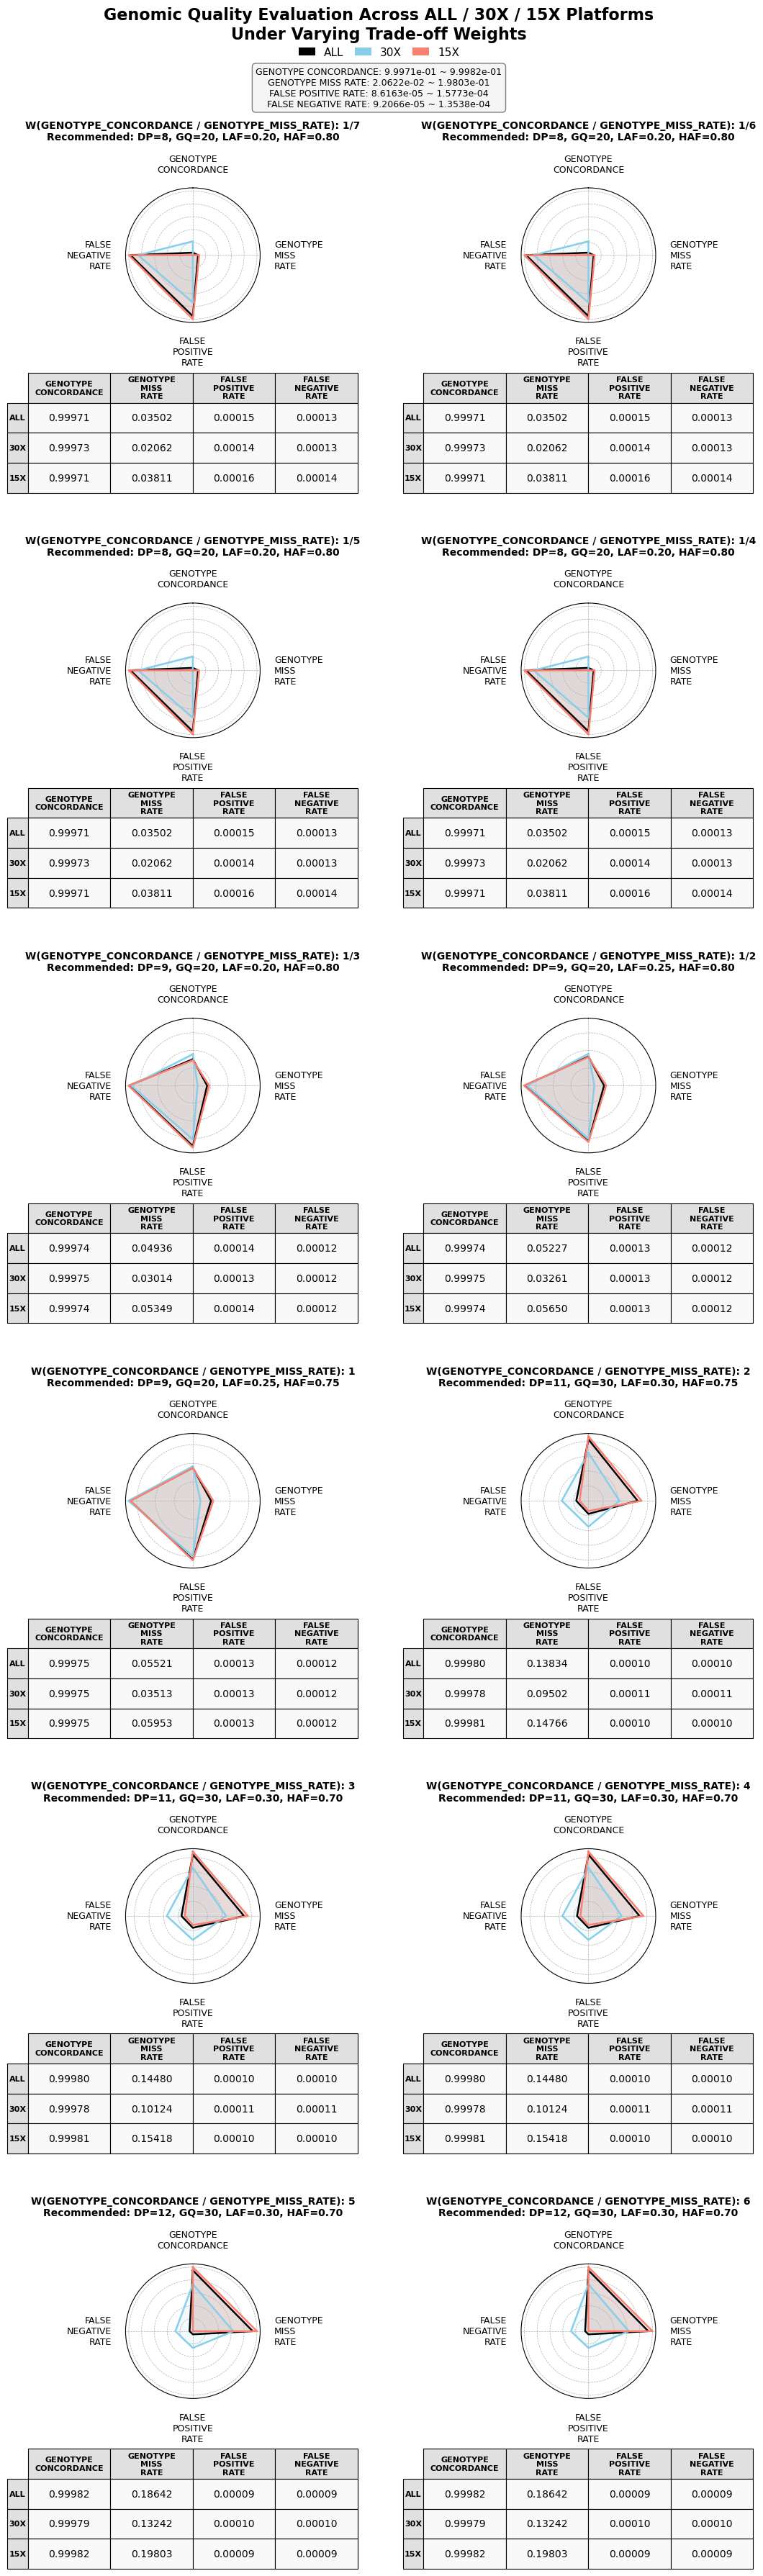

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from fractions import Fraction
from matplotlib.patches import Patch
from matplotlib.patches import FancyBboxPatch

# === 数据准备（final_df 应已定义） ===
platforms = ['ALL', '30X', '15X']
metrics = ['GENOTYPE_CONCORDANCE', 'GENOTYPE_MISS_RATE', 'FALSE_POSITIVE_RATE', 'FALSE_NEGATIVE_RATE']
weights = [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6]

metric_ranges = {
    metric: (
        final_df[[f"{metric}_{p}" for p in platforms]].min().min(),
        final_df[[f"{metric}_{p}" for p in platforms]].max().max()
    )
    for metric in metrics
}

def normalize(value, metric):
    min_v, max_v = metric_ranges[metric]
    return (value - min_v) / (max_v - min_v) if max_v > min_v else 0.5  # Normalize to 0.5 if range is zero

def plot_radar(ax, data_dict, title, metric_ranges, color_map):
    labels = list(data_dict[next(iter(data_dict))].keys())
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    xtick_labels = [metric.replace('_', '\n') for metric in labels]
    ax.set_xticklabels(xtick_labels, fontsize=9)

    # 手动调整左右两个label的对齐方式
    for label, angle in zip(ax.get_xticklabels(), angles):
        angle_deg = np.degrees(angle)
        if angle_deg == 90:  # 右边标签
            label.set_horizontalalignment('left')
        elif angle_deg == 270:  # 左边标签
            label.set_horizontalalignment('right')
        elif angle_deg == 0:  # 顶部标签
            label.set_verticalalignment('bottom')
        elif angle_deg == 180:  # 底部标签
            label.set_verticalalignment('top')
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', linewidth=0.5)

    for platform, values in data_dict.items():
        values_list = [normalize(values[m], m) for m in labels]
        values_list += values_list[:1]
        ax.plot(angles, values_list, label=platform, color=color_map[platform], linewidth=1.8)
        ax.fill(angles, values_list, color=color_map[platform], alpha=0.1)

    ax.set_title(title, fontsize=10, fontweight='bold', pad=14)

def plot_table(ax, data_dict):
    ax.axis('off')
    row_labels = list(data_dict.keys())
    col_labels = list(next(iter(data_dict.values())).keys())
    col_labels_wrapped = [label.replace('_', '\n') for label in col_labels]

    cell_text = [
        [f"{data_dict[platform][metric]:.5f}" for metric in col_labels]
        for platform in row_labels
    ]

    table = ax.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels_wrapped,
        loc='center',
        cellLoc='center',
        rowLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(0.8)
        cell.set_text_props(ha='center', va='center')

        if row == 0:
            cell.set_facecolor('#e0e0e0')
            cell.set_text_props(weight='bold', fontsize=8)
        elif col == -1:
            cell.set_facecolor('#e0e0e0')
            cell.set_text_props(weight='bold', fontsize=8)
        else:
            cell.set_facecolor('#f9f9f9')
            cell.set_text_props(fontsize=10)

    table.scale(1.0, 2.5)

# === 图像布局 ===
num_weights = len(weights)
ncols = 2
nrows = int(np.ceil(num_weights / ncols))

fig = plt.figure(figsize=(13, nrows * 7))
outer_gs = GridSpec(nrows, ncols, hspace=0.65)
color_map = {'ALL': 'black', '30X': 'skyblue', '15X': 'salmon'}

for idx, w in enumerate(weights):
    weight_str = str(Fraction(w).limit_denominator())
    row = idx // ncols
    col = idx % ncols

    inner_gs = GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[row, col],
        height_ratios=[10, 1.0],
        hspace=1.4
    )

    ax_radar = fig.add_subplot(inner_gs[0], polar=True)
    ax_table = fig.add_subplot(inner_gs[1])

    subset = final_df[final_df['W(GENOTYPE_CONCORDANCE / GENOTYPE_MISS_RATE)'] == weight_str]
    if subset.empty:
        continue

    row_data = subset.iloc[0]
    data_dict = {
        p: {m: row_data[f"{m}_{p}"] for m in metrics}
        for p in platforms
    }

    title = (
        f"W(GENOTYPE_CONCORDANCE / GENOTYPE_MISS_RATE): {weight_str}\n"
        f"Recommended: DP={int(row_data['Recommended DP'])}, "
        f"GQ={int(row_data['Recommended GQ'])}, "
        f"LAF={row_data['Recommended LAF']:.2f}, HAF={row_data['Recommended HAF']:.2f}"
    )

    plot_radar(ax_radar, data_dict, title, metric_ranges, color_map)
    plot_table(ax_table, data_dict)

# === 添加主标题和图例 ===
fig.suptitle(
    "Genomic Quality Evaluation Across ALL / 30X / 15X Platforms\nUnder Varying Trade-off Weights",
    fontsize=16,
    fontweight='bold',
    y=0.94
)

legend_elements = [
    Patch(facecolor='black', label='ALL'),
    Patch(facecolor='skyblue', label='30X'),
    Patch(facecolor='salmon', label='15X'),
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),
    ncol=3,
    columnspacing=1.0,
    handlelength=1.5,
    fontsize=11,
    frameon=False
)

# === 添加带背景和边框的指标说明框 ===
metric_text = "\n".join([
    f"{m.replace('_', ' ')}: {metric_ranges[m][0]:.4e} ~ {metric_ranges[m][1]:.4e}" for m in metrics
])

# 添加一个背景框 + 文本
fig.text(
    0.5, 0.92,  # 比 legend 稍下方，居中
    metric_text,
    ha='center', va='top',
    fontsize=9, color='black',
    bbox=dict(
        boxstyle='round,pad=0.4',
        facecolor='#f5f5f5',
        edgecolor='gray',
        linewidth=1
    )
)

# plt.savefig("final_radar_table_adjusted_size.png", dpi=300)
plt.style.use('default')
plt.show()